In [1]:
from model_phantom_DB import *
from linares_plot import * 
import itertools

%matplotlib inline
%config InlineBackend.figure_format = 'png' ## 'svg'

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import pandas as pd

In [2]:
### en vez de cargar todos los datos, solo cargar las y
### las X cargo solo los datos de la neurona 0

# simulations_ON_rE = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_re.xlsx'
# simulations_ON_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_targets.xlsx'

# simulations_OFF_rE = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_re.xlsx'
# simulations_OFF_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_targets.xlsx'

# y_off_all=pd.read_excel(simulations_OFF_targets).values
# X_off_all= pd.read_excel(simulations_OFF_rE).values

# y_on_all=pd.read_excel(simulations_ON_targets).values
# X_on_all= pd.read_excel(simulations_ON_rE).values

In [3]:
##guardar los datos de la neurona 0, 1, y 256 
# simpl_X_on_all= pd.DataFrame(X_on_all[:, 0])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron0_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, 0])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron0_simuls_off_class_re.xlsx')


# simpl_X_on_all= pd.DataFrame(X_on_all[:, 1])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron1_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, 1])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron1_simuls_off_class_re.xlsx')


# simpl_X_on_all= pd.DataFrame(X_on_all[:, int(512/2)])
# simpl_X_on_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_on_class_re.xlsx')
# simpl_X_off_all= pd.DataFrame(X_off_all[:, int(512/2)])
# simpl_X_off_all.to_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_off_class_re.xlsx')

In [10]:
simpl_X_on_all = pd.read_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_on_class_re.xlsx')
simpl_X_off_all = pd.read_excel('C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\neuron256_simuls_off_class_re.xlsx')


simulations_ON_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_on_class_targets.xlsx'
simulations_OFF_targets = 'C:\\Users\\David\\Desktop\\IDIBAPS\\simulations_christos\\simuls_off_class_targets.xlsx'

y_off_all=pd.read_excel(simulations_OFF_targets).values
y_on_all=pd.read_excel(simulations_ON_targets).values


In [3]:
Window = 20 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)


wind=1

reps_=100

## get y_off
y_off=y_off_all
bool_int = (y_off>=inic) & (y_off<=fin) 
y_off = y_off[bool_int]
y_off_t = np.reshape(y_off, (len(y_off),1))
#y_off= label_binarize(y_off_t, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
# y_off_t = np.array((y_off_t==180)*1 )
# y_off= label_binarize(y_off_t, classes=np.arange(0, 2, wind)) #matrix (1,0,0,...,0)

boo=[]
for i in range(len(y_off_t)):
    if y_off_t[i]<175:
        boo.append(1)
    elif y_off_t[i]>185:
        boo.append(1)
    else:
        boo.append(2)


y_off_t = np.array(boo)    
y_off= label_binarize(y_off_t, classes=[1,2]) #matrix (1,0,0,...,0)




n_classes = y_off.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_off = X_off_all[bool_reshaped,n_neuron]
X_off = simpl_X_off_all[bool_reshaped]

X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
y_on=y_on_all
bool_int =  (y_on>=inic) & (y_on<=fin)
y_on = y_on[bool_int]
y_on_t = np.reshape(y_on, (len(y_on),1))
#y_on= label_binarize(y_on_t, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
# y_off_t = np.array((y_on_t==180)*1 )
# y_off= label_binarize(y_on_t, classes=np.arange(0, 2, wind)) #matrix (1,0,0,...,0)


boo=[]
for i in range(len(y_on_t)):
    if y_on_t[i]<175:
        boo.append(1)
    elif y_on_t[i]>185:
        boo.append(1)
    else:
        boo.append(2)


y_on_t = np.array(boo)    
y_on= label_binarize(y_on_t, classes=[1,2]) #matrix (1,0,0,...,0)


n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_on = X_on_all[bool_reshaped,n_neuron]
X_on = simpl_X_on_all[bool_reshaped]

X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        #print(rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


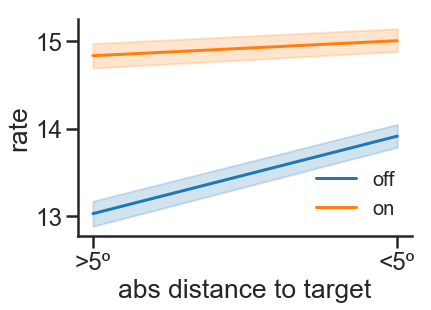

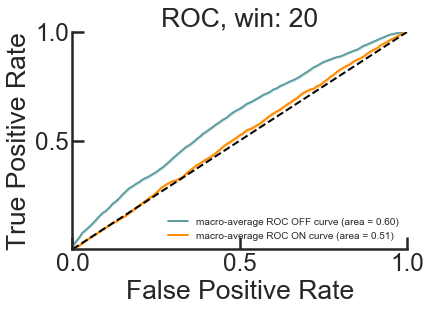

Ttest_indResult(statistic=-33.37422986776669, pvalue=3.075221421731552e-83)

In [5]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.xticks([1,  2], ['>5º', '<5º'])
plt.xlabel('abs distance to target')
plt.legend(fontsize=20, frameon=False)
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


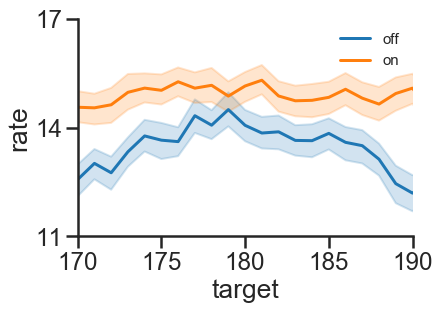

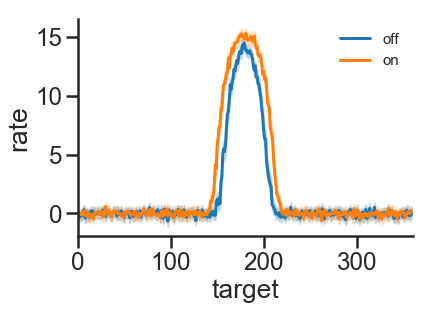

In [7]:
Window = 360 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)


wind=1



## get y_off
y_off=y_off_all
bool_int = (y_off>=inic) & (y_off<=fin) 
y_off = y_off[bool_int]
y_off_t = np.reshape(y_off, (len(y_off),1))
#### X_off = X_off_all[bool_reshaped,n_neuron]
X_off = simpl_X_off_all[bool_reshaped]
X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
y_on=y_on_all
bool_int =  (y_on>=inic) & (y_on<=fin)
y_on = y_on[bool_int]
y_on_t = np.reshape(y_on, (len(y_on),1))
## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_on = X_on_all[bool_reshaped,n_neuron]
X_on = simpl_X_on_all[bool_reshaped]
X_on =np.reshape(X_on, (len(X_on),1))


plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.ylim(11,17)
plt.yticks([11,14,17])
plt.xlim(170,190)
plt.legend(frameon=False, loc=1, fontsize=15)
plt.show()



plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
#plt.ylim(11,17)
#plt.yticks([11,14,17])
plt.xlim(0,360)
plt.legend(frameon=False, loc=1, fontsize=15)
plt.show()


In [58]:
y_off=y_off_all.copy()
X_off=simpl_X_off_all.copy()

y_on=y_on_all.copy()
X_on=simpl_X_on_all.copy()

In [ ]:
### Instead of window of 20, get the whole 360 degrees 

In [38]:
y_off=y_off_all.copy()
X_off=simpl_X_off_all.copy()

y_on=y_on_all.copy()
X_on=simpl_X_on_all.copy()

In [39]:
Window = 360 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)
lim_inf = 175
lim_sup = 185
sampling_ = 5

wind=1

reps_=10

## get y_off
uniques_ = np.unique(y_off[::sampling_])
bool_int = np.array([y_off[x] in uniques_ for x in range(len(y_off))])
y_off = y_off[bool_int]
y_off_tar = np.reshape(y_off, (len(y_off),1))


boo=[]
for i in range(len(y_off_t)):
    if y_off_tar[i]<lim_inf:
        boo.append(1)
    elif y_off_tar[i]>lim_sup:
        boo.append(1)
    else:
        boo.append(2)


y_off_t = np.array(boo)    
y_off= label_binarize(y_off_t, classes=[1,2]) #matrix (1,0,0,...,0)


n_classes = y_off.shape[1]

np.unique(y_off)
np.unique(y_off_t)
np.unique(y_off_tar)

IndexError: index 7200 is out of bounds for axis 0 with size 7200

In [49]:
Window = 360 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)


wind=1

reps_=10

## get y_off
y_off=y_off_all
bool_int = (y_off>=inic) & (y_off<=fin) 
y_off = y_off[bool_int]
y_off_t = np.reshape(y_off, (len(y_off),1))
uniques_ = np.unique(y_off_t[::5])

In [51]:
y_off_t[y_off_t==any(uniques_)]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [61]:
y_off_t[np.array([y_off_t[x] in uniques_ for x in range(len(y_off_t))])]

array([[  0],
       [  5],
       [ 10],
       ...,
       [345],
       [350],
       [355]], dtype=int64)

In [55]:
y_off_t

array([[  0],
       [  1],
       [  2],
       ...,
       [357],
       [358],
       [359]], dtype=int64)

In [67]:
np.unique(y_off[::5])
np.array([y_off_t[x] in uniques_ for x in range(len(y_off_t))])
y_off_t

array([1, 1, 1, ..., 1, 1, 1])

In [68]:
y_off_all

array([[  0],
       [  1],
       [  2],
       ...,
       [357],
       [358],
       [359]], dtype=int64)

In [182]:
y_off=y_off_all.copy()
X_off=simpl_X_off_all.copy()

y_on=y_on_all.copy()
X_on=simpl_X_on_all.copy()

In [183]:
Window = 360 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)
lim_inf = 170
lim_sup = 190
sampling_ = 3
##wind=100
reps_=10


uniques_ = np.unique(y_off[::sampling_])


## get y_off
bool_int = np.array([y_off[x] in uniques_ for x in range(len(y_off))])
y_off = y_off[bool_int]
y_off_tar = np.reshape(y_off, (len(y_off),1))


boo=[]
for i in range(len(y_off_tar)):
    if y_off_tar[i]<lim_inf:
        boo.append(0)
    elif y_off_tar[i]>lim_sup:
        boo.append(0)
    else:
        boo.append(1)


y_off_t = np.array(boo)    
y_off= label_binarize(y_off_t, classes=[0,1]) #matrix (1,0,0,...,0)


n_classes = y_off.shape[1]


## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
X_off = X_off[bool_reshaped]
X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
bool_int =  np.array([y_on[x] in uniques_ for x in range(len(y_on))])
y_on = y_on[bool_int]
y_on_tar = np.reshape(y_on, (len(y_on),1))


boo=[]
for i in range(len(y_on_tar)):
    if y_on_tar[i]<lim_inf:
        boo.append(0)
    elif y_on_tar[i]>lim_sup:
        boo.append(0)
    else:
        boo.append(1)


y_on_t = np.array(boo)    
y_on= label_binarize(y_on_t, classes=[0,1]) #matrix (1,0,0,...,0)


n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
X_on = X_on[bool_reshaped]
X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        print(rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


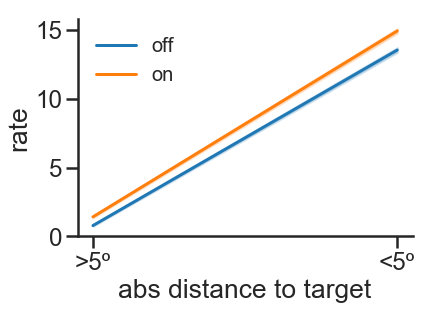

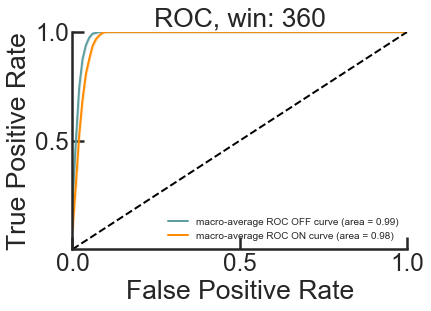

Ttest_indResult(statistic=-12.29994390002721, pvalue=3.3879603107380534e-10)

In [184]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.xticks([0,1], ['>5º', '<5º'])
plt.xlabel('abs distance to target')
plt.legend(fontsize=20, frameon=False)
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

In [ ]:
### 10 de la window y 10 de fuera

In [166]:
Window = 10 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)

##wind=100
reps_=300


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []


for stimulation in ['ON', 'OFF']:
    ### many train and test to validate the measure
    for rep in range(reps_):
        if stimulation=='OFF': 
            y_off=y_off_all.copy()
            X_off=simpl_X_off_all.copy()
            print(rep)
            u1 = random.randint(0, inic, int(Window/2))
            u2 = random.randint(fin+1, 360, int(Window/2))
            uniques_360 = np.concatenate([u1,u2])
            uniques_window= np.arange(inic, fin, 1)
            uniques_ = np.concatenate([uniques_360, uniques_window])
            ## get y_off
            bool_int = np.array([y_off[x] in uniques_ for x in range(len(y_off))])
            y_off = y_off[bool_int]
            y_off_tar = np.reshape(y_off, (len(y_off),1))
            boo=[]
            for i in range(len(y_off_tar)):
                if y_off_tar[i]<inic:
                    boo.append(0)
                elif y_off_tar[i]>fin:
                    boo.append(0)
                else:
                    boo.append(1)
            y_off_t = np.array(boo)    
            y_off= label_binarize(y_off_t, classes=[0,1]) #matrix (1,0,0,...,0)
            n_classes = y_off.shape[1]
            ## get X_off
            bool_reshaped = np.reshape(bool_int, (len(bool_int)))
            X_off = X_off[bool_reshaped]
            X_off =np.reshape(X_off, (len(X_off),1))
            #####
            X=X_off
            y=y_off
        elif stimulation=='ON': 
            y_on=y_on_all.copy()
            X_on=simpl_X_on_all.copy()
            print(rep)
            u1 = random.randint(0, inic, int(Window/2))
            u2 = random.randint(fin+1, 360, int(Window/2))
            uniques_360 = np.concatenate([u1,u2])
            uniques_window= np.arange(inic, fin, 1)
            uniques_ = np.concatenate([uniques_360, uniques_window])
            ## get y_on
            bool_int = np.array([y_on[x] in uniques_ for x in range(len(y_on))])
            y_on = y_on[bool_int]
            y_on_tar = np.reshape(y_on, (len(y_on),1))
            boo=[]
            for i in range(len(y_on_tar)):
                if y_on_tar[i]<inic:
                    boo.append(0)
                elif y_on_tar[i]>fin:
                    boo.append(0)
                else:
                    boo.append(1)
            y_on_t = np.array(boo)    
            y_on= label_binarize(y_on_t, classes=[0,1]) #matrix (1,0,0,...,0)
            n_classes = y_on.shape[1]
            ## get X_on
            bool_reshaped = np.reshape(bool_int, (len(bool_int)))
            X_on = X_on[bool_reshaped]
            X_on =np.reshape(X_on, (len(X_on),1))
            #####
            X=X_on
            y=y_on
        
        
        ##
        ##
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [167]:
print(len(X_off[0].values), len(y_off_t))
print(len(X_on[0].values), len(y_on_t))


2000 2000
2000 2000


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


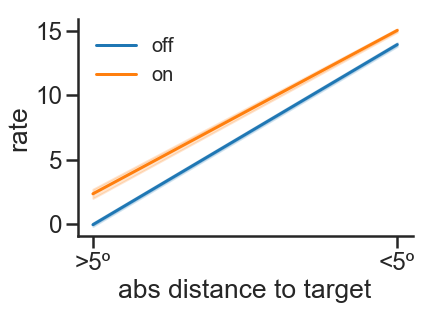

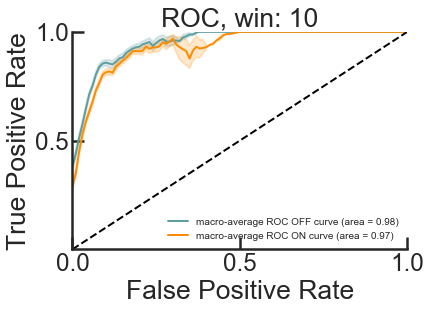

Ttest_indResult(statistic=-4.289273323573671, pvalue=2.0900543347437064e-05)

In [168]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.xticks([0,1], ['>5º', '<5º'])
plt.xlabel('abs distance to target')
plt.legend(fontsize=20, frameon=False)
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

In [174]:
Window = 10 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)

##wind=100
reps_=100


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []


for stimulation in ['ON', 'OFF']:
    ### many train and test to validate the measure
    for rep in range(reps_):
        if stimulation=='OFF': 
            y_off=y_off_all.copy()
            X_off=simpl_X_off_all.copy()
            print('off', rep)
            #u1 = random.randint(0, inic, int(Window/2))
            #u2 = random.randint(fin+1, 360, int(Window/2))
            u1 = random.randint(0, inic, Window*2)
            u2 = random.randint(fin+1, 360, Window*2)
            uniques_360 = np.concatenate([u1,u2])
            uniques_window= np.arange(inic, fin, 1)
            uniques_ = np.concatenate([uniques_360, uniques_window])
            ## get y_off
            bool_int = np.array([y_off[x] in uniques_ for x in range(len(y_off))])
            y_off = y_off[bool_int]
            y_off_tar = np.reshape(y_off, (len(y_off),1))
            boo=[]
            for i in range(len(y_off_tar)):
                if y_off_tar[i]<inic:
                    boo.append(0)
                elif y_off_tar[i]>fin:
                    boo.append(0)
                else:
                    boo.append(1)
            y_off_t = np.array(boo)    
            y_off= label_binarize(y_off_t, classes=[0,1]) #matrix (1,0,0,...,0)
            n_classes = y_off.shape[1]
            ## get X_off
            bool_reshaped = np.reshape(bool_int, (len(bool_int)))
            X_off = X_off[bool_reshaped]
            X_off =np.reshape(X_off, (len(X_off),1))
            #####
            X=X_off
            y=y_off
        elif stimulation=='ON': 
            y_on=y_on_all.copy()
            X_on=simpl_X_on_all.copy()
            print('on', rep)
            #u1 = random.randint(0, inic, int(Window/2))
            #u2 = random.randint(fin+1, 360, int(Window/2))
            u1 = random.randint(0, inic, Window*2)
            u2 = random.randint(fin+1, 360, Window*2)
            uniques_360 = np.concatenate([u1,u2])
            uniques_window= np.arange(inic, fin, 1)
            uniques_ = np.concatenate([uniques_360, uniques_window])
            ## get y_on
            bool_int = np.array([y_on[x] in uniques_ for x in range(len(y_on))])
            y_on = y_on[bool_int]
            y_on_tar = np.reshape(y_on, (len(y_on),1))
            boo=[]
            for i in range(len(y_on_tar)):
                if y_on_tar[i]<inic:
                    boo.append(0)
                elif y_on_tar[i]>fin:
                    boo.append(0)
                else:
                    boo.append(1)
            y_on_t = np.array(boo)    
            y_on= label_binarize(y_on_t, classes=[0,1]) #matrix (1,0,0,...,0)
            n_classes = y_on.shape[1]
            ## get X_on
            bool_reshaped = np.reshape(bool_int, (len(bool_int)))
            X_on = X_on[bool_reshaped]
            X_on =np.reshape(X_on, (len(X_on),1))
            #####
            X=X_on
            y=y_on
        
        
        ##
        ##
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

on 0
on 1
on 2
on 3
on 4
on 5
on 6
on 7
on 8
on 9
on 10
on 11
on 12
on 13
on 14
on 15
on 16
on 17
on 18
on 19
on 20
on 21
on 22
on 23
on 24
on 25
on 26
on 27
on 28
on 29
on 30
on 31
on 32
on 33
on 34
on 35
on 36
on 37
on 38
on 39
on 40
on 41
on 42
on 43
on 44
on 45
on 46
on 47
on 48
on 49
on 50
on 51
on 52
on 53
on 54
on 55
on 56
on 57
on 58
on 59
on 60
on 61
on 62
on 63
on 64
on 65
on 66
on 67
on 68
on 69
on 70
on 71
on 72
on 73
on 74
on 75
on 76
on 77
on 78
on 79
on 80
on 81
on 82
on 83
on 84
on 85
on 86
on 87
on 88
on 89
on 90
on 91
on 92
on 93
on 94
on 95
on 96
on 97
on 98
on 99
off 0
off 1
off 2
off 3
off 4
off 5
off 6
off 7
off 8
off 9
off 10
off 11
off 12
off 13
off 14
off 15
off 16
off 17
off 18
off 19
off 20
off 21
off 22
off 23
off 24
off 25
off 26
off 27
off 28
off 29
off 30
off 31
off 32
off 33
off 34
off 35
off 36
off 37
off 38
off 39
off 40
off 41
off 42
off 43
off 44
off 45
off 46
off 47
off 48
off 49
off 50
off 51
off 52
off 53
off 54
off 55
off 56
off 57
off 58
off 59


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


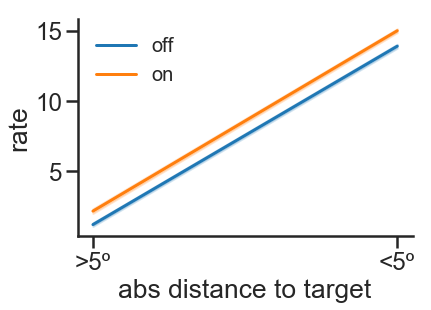

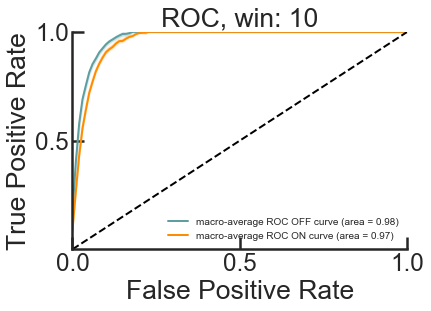

Ttest_indResult(statistic=-5.857327632082134, pvalue=1.9324004486272903e-08)

In [175]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.xticks([0,1], ['>5º', '<5º'])
plt.xlabel('abs distance to target')
plt.legend(fontsize=20, frameon=False)
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

In [177]:
len(roc_mean_on)

100

In [ ]:
@@@AQUIIIIIIIII

In [99]:
y_off=y_off_all.copy()
X_off=simpl_X_off_all.copy()

y_on=y_on_all.copy()
X_on=simpl_X_on_all.copy()

In [100]:
Window = 360 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)
lim_inf = 175
lim_sup = 185
sampling_ = 10
##wind=100
reps_=10


uniques_ = np.unique(y_off[::sampling_])
#uniques_ = np.arange(inic, fin, sampling_)


## get y_off
bool_int = np.array([y_off[x] in uniques_ for x in range(len(y_off))])
y_off = y_off[bool_int]
y_off_tar = np.reshape(y_off, (len(y_off),1))


boo=[]
for i in range(len(y_off_tar)):
    if y_off_tar[i]<lim_inf:
        boo.append(0)
    elif y_off_tar[i]>lim_sup:
        boo.append(0)
    else:
        boo.append(1)


y_off_t = np.array(boo)    
y_off= label_binarize(y_off_t, classes=[0,1]) #matrix (1,0,0,...,0)


n_classes = y_off.shape[1]


## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
X_off = X_off[bool_reshaped]
X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
bool_int =  np.array([y_on[x] in uniques_ for x in range(len(y_on))])
y_on = y_on[bool_int]
y_on_tar = np.reshape(y_on, (len(y_on),1))


boo=[]
for i in range(len(y_on_tar)):
    if y_on_tar[i]<lim_inf:
        boo.append(0)
    elif y_on_tar[i]>lim_sup:
        boo.append(0)
    else:
        boo.append(1)


y_on_t = np.array(boo)    
y_on= label_binarize(y_on_t, classes=[0,1]) #matrix (1,0,0,...,0)


n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
X_on = X_on[bool_reshaped]
X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        print(rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

0
1
2
3
4
5
6


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


7
8
9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0
1
2
3
4
5
6
7
8
9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


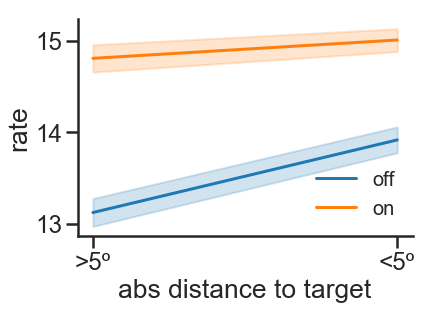

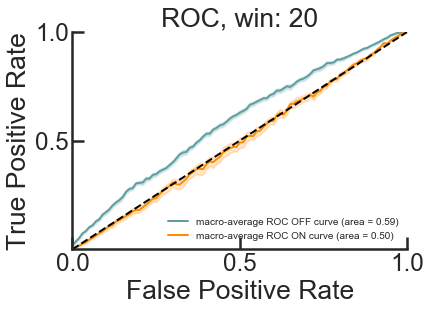

Ttest_indResult(statistic=-8.020476563750009, pvalue=2.3630581277274038e-07)

In [101]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.xticks([0,1], ['>5º', '<5º'])
plt.xlabel('abs distance to target')
plt.legend(fontsize=20, frameon=False)
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

In [91]:
y_off=y_off_all.copy()
X_off=simpl_X_off_all.copy()

y_on=y_on_all.copy()
X_on=simpl_X_on_all.copy()

In [92]:
Window = 20 ###20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)


wind=1

reps_=10

## get y_off
#y_off=y_off_all
bool_int = (y_off>=inic) & (y_off<=fin) 
y_off = y_off[bool_int]
y_off_t = np.reshape(y_off, (len(y_off),1))
#y_off= label_binarize(y_off_t, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
# y_off_t = np.array((y_off_t==180)*1 )
# y_off= label_binarize(y_off_t, classes=np.arange(0, 2, wind)) #matrix (1,0,0,...,0)

boo=[]
for i in range(len(y_off_t)):
    if y_off_t[i]<175:
        boo.append(0)
    elif y_off_t[i]>185:
        boo.append(0)
    else:
        boo.append(1)


y_off_t = np.array(boo)    
y_off= label_binarize(y_off_t, classes=[0,1]) #matrix (1,0,0,...,0)




n_classes = y_off.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_off = X_off_all[bool_reshaped,n_neuron]
#X_off = simpl_X_off_all[bool_reshaped]
X_off = X_off[bool_reshaped]

X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
#y_on=y_on_all
bool_int =  (y_on>=inic) & (y_on<=fin)
y_on = y_on[bool_int]
y_on_t = np.reshape(y_on, (len(y_on),1))
#y_on= label_binarize(y_on_t, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
# y_off_t = np.array((y_on_t==180)*1 )
# y_off= label_binarize(y_on_t, classes=np.arange(0, 2, wind)) #matrix (1,0,0,...,0)


boo=[]
for i in range(len(y_on_t)):
    if y_on_t[i]<175:
        boo.append(0)
    elif y_on_t[i]>185:
        boo.append(0)
    else:
        boo.append(1)


y_on_t = np.array(boo)    
y_on= label_binarize(y_on_t, classes=[0,1]) #matrix (1,0,0,...,0)


n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_on = X_on_all[bool_reshaped,n_neuron]
#X_on = simpl_X_on_all[bool_reshaped]
X_on = X_on[bool_reshaped]


X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000)) #, max_iter=10000

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        print(rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            #fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            fpr[i], tpr[i], _ = roc_curve(y_test[:], y_score[:])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

0
1
2
3
4
5
6
7
8
9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0
1
2
3
4
5
6
7
8
9


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


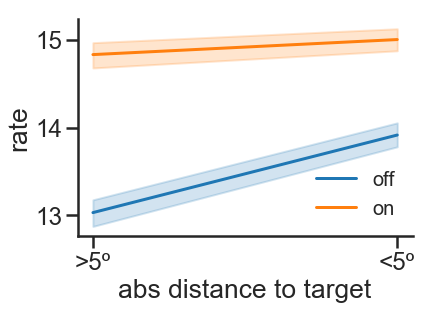

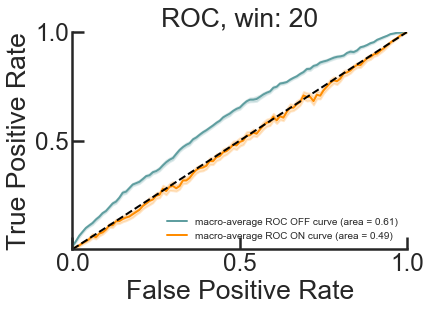

Ttest_indResult(statistic=-9.85662290760136, pvalue=1.1148492297195517e-08)

In [93]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.xticks([0,1], ['>5º', '<5º'])
plt.xlabel('abs distance to target')
plt.legend(fontsize=20, frameon=False)
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

scipy.stats.ttest_ind(roc_mean_on, roc_mean_off)

In [5]:
Window = 20
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)

Window2=5

wind=1

reps_=10

## get y_off
y_off=y_off_all
bool_int = (y_off>=inic) & (y_off<=fin) 
y_off = y_off[bool_int]
y_off_t = np.reshape(y_off, (len(y_off),1))
y_off= label_binarize(y_off_t, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
n_classes = y_off.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_off = X_off_all[bool_reshaped,n_neuron]
X_off = simpl_X_off_all[bool_reshaped]

X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
y_on=y_on_all
bool_int =  (y_on>=inic) & (y_on<=fin)
y_on = y_on[bool_int]
y_on_t = np.reshape(y_on, (len(y_on),1))
y_on= label_binarize(y_on_t, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_on = X_on_all[bool_reshaped,n_neuron]
X_on = simpl_X_on_all[bool_reshaped]

X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000))

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        #print(rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        
        #X_test = X_test[y_test[:, int(Window/2) ]==1]
        #y_test = y_test[y_test[:, int(Window/2)]==1]
        
        #bool_ = np.array([any(y_test[x ,int(Window/2)-int(Window2/2): int(Window/2)+int(Window2/2)])==1 for x in range(len(y_test))])
        #X_test = X_test[bool_]
        #y_test = y_test[bool_]
        #n_classes = y_test.shape[1]
        
        
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


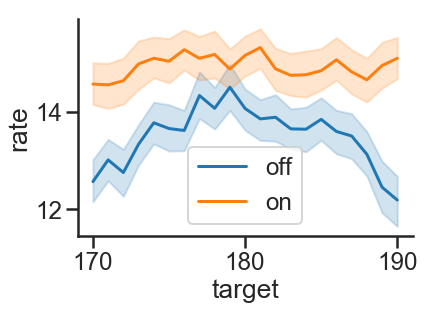

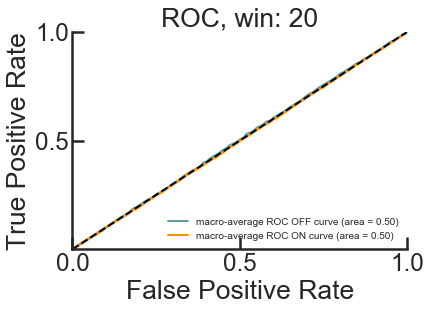

In [6]:
plt.figure()
off = pd.DataFrame({'rate':X_off[0].values, 'target':pd.DataFrame(y_off_t)[0].values})
on = pd.DataFrame({'rate':X_on[0].values, 'target':pd.DataFrame(y_on_t)[0].values})
sns.lineplot(x='target', y='rate', data=off, label='off')
sns.lineplot(x='target', y='rate', data=on, label='on')
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.show()


plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

In [139]:
np.shape(y_test)
y_test[y_test[:, 15]==1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [143]:
np.shape(y_test)


(620, 30)

In [145]:
np.shape(X_test[y_test[:, 15]==1])
X_test[y_test[:, 15]==1]

,0
12060,10.189526
13860,14.026511
2700,14.368912
540,13.424863
26460,13.397340
6300,12.886241
35100,14.533621
900,11.577435
13500,13.762397
28980,14.035179


In [146]:
X_test[y_test[:, 0]==1]

,0
22125,10.443054
885,9.948819
17085,9.938609
29685,6.882805
19245,10.103738
11325,9.776393
13845,12.422727
33285,11.142256
33645,14.158433
35085,13.121079


In [75]:
Window = 6
n_neuron=180 
inic=n_neuron - int(Window/2)
fin=n_neuron + int(Window/2)

wind=1

reps_=50

## get y_off
y_off=y_off_all
bool_int = (y_off>=inic) & (y_off<=fin) 
y_off = y_off[bool_int]
y_off = np.reshape(y_off, (len(y_off),1))
y_off= label_binarize(y_off, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
n_classes = y_off.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_off = X_off_all[bool_reshaped,n_neuron]
X_off = simpl_X_off_all[bool_reshaped]

X_off =np.reshape(X_off, (len(X_off),1))

########################################################################

## get y_on
y_on=y_on_all
bool_int =  (y_on>=inic) & (y_on<=fin)
y_on = y_on[bool_int]
y_on = np.reshape(y_on, (len(y_on),1))
y_on= label_binarize(y_on, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
n_classes = y_on.shape[1]

## get X_off
bool_reshaped = np.reshape(bool_int, (len(bool_int)))
#### X_on = X_on_all[bool_reshaped,n_neuron]
X_on = simpl_X_on_all[bool_reshaped]

X_on =np.reshape(X_on, (len(X_on),1))


##classifier to use
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000))

fpr_mean_off = []
tpr_mean_off = []
roc_mean_off = []

fpr_mean_on = []
tpr_mean_on = []
roc_mean_on = []



for stimulation in ['ON', 'OFF']:
    if stimulation=='ON':
        X=X_on
        y=y_on
    elif stimulation=='OFF':
        X=X_off
        y=y_off
    
    ###
    ### many train and test to validate the measure
    for rep in range(reps_):
        print(rep)
        ## split train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=None)
        X_train =np.reshape(X_train, (len(X_train),1))
        X_test =np.reshape(X_test, (len(X_test),1))
        # score
        #fitted = classifier.fit(X_train, y_train)
        #y_score = fitted.decision_function(X_test)
        y_score = classifier.fit(X_train, y_train).decision_function(X_test)

        ## Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr= dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ### Compute mean ROC curve

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        #
        if stimulation=='ON':
            fpr_mean_on.append(fpr["macro"])
            tpr_mean_on.append(tpr["macro"])
            roc_mean_on.append(roc_auc["macro"])
        elif stimulation=='OFF':
            fpr_mean_off.append(fpr["macro"])
            tpr_mean_off.append(tpr["macro"])
            roc_mean_off.append(roc_auc["macro"])


    
####

0
1
2


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


30
31
32
33
34
35
36
37
38
39
40
41


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


18
19
20
21
22
23
24
25


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


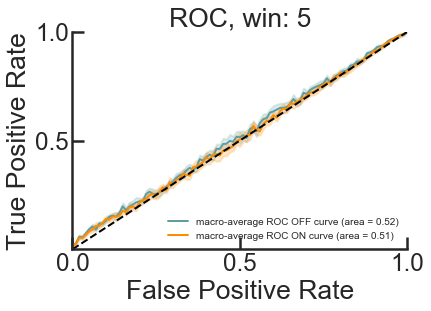

In [74]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


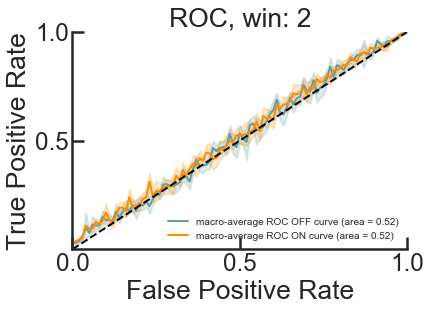

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


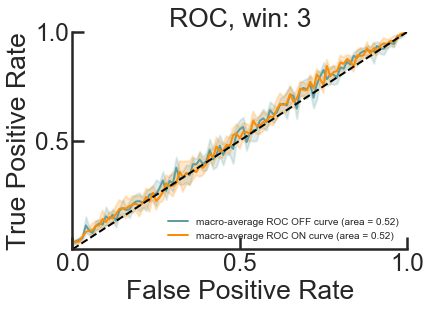

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

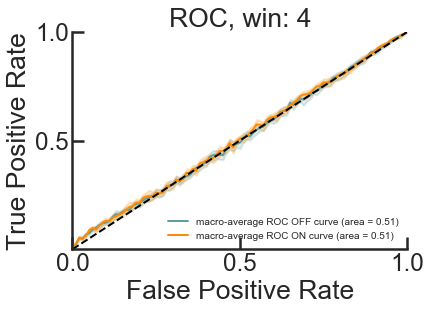

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

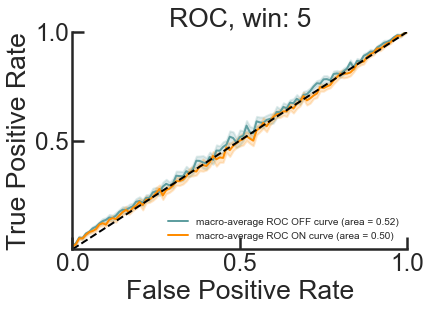

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

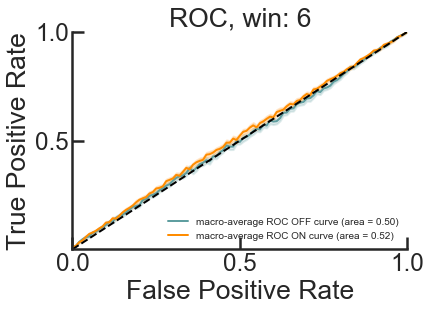

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

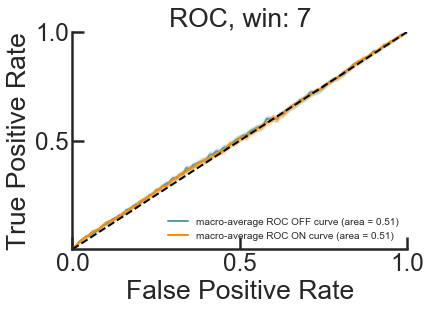

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


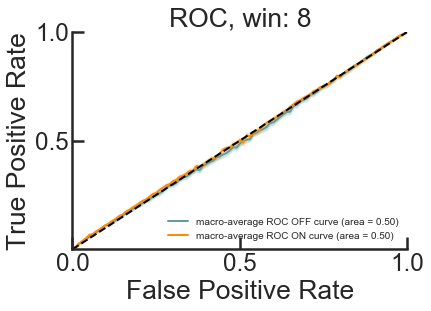

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

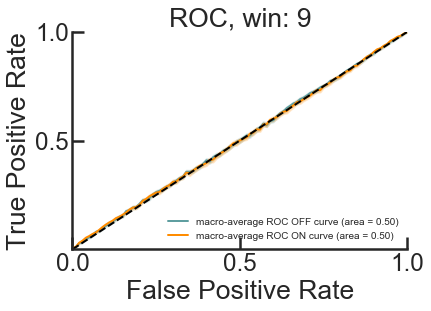

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

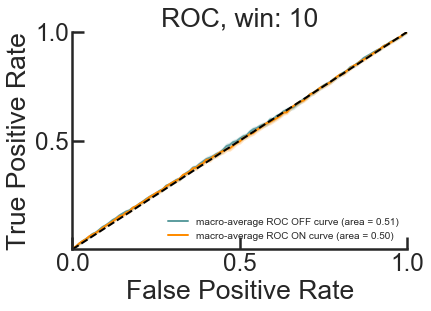

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

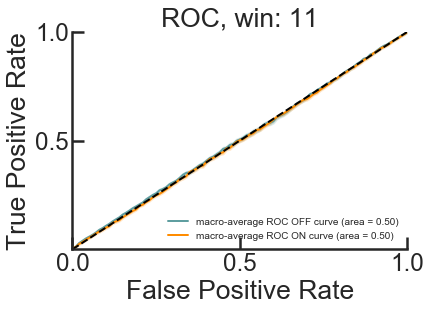

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

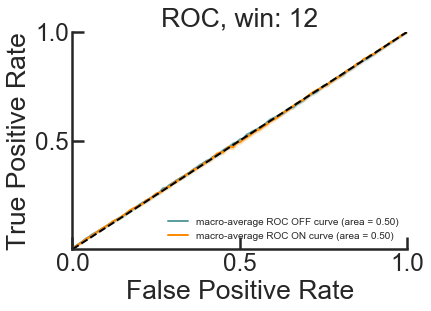

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

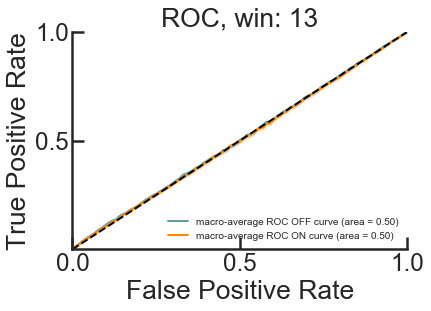

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

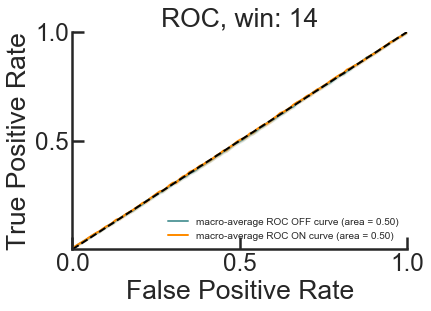

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

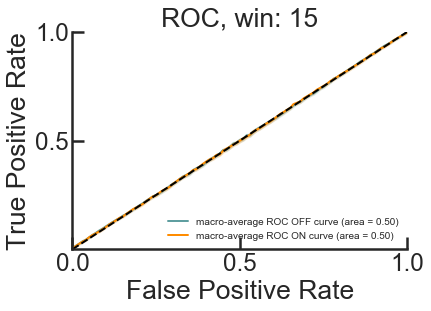

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

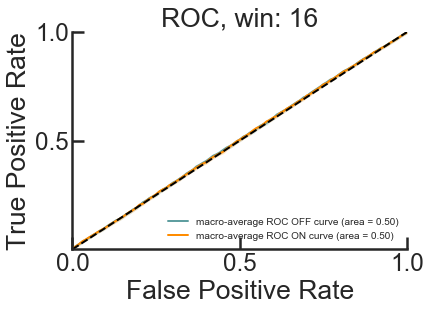

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

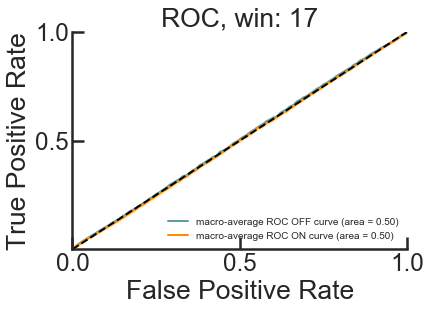

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

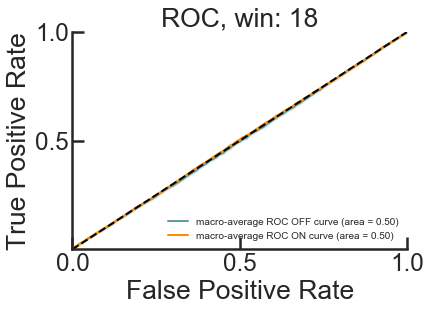

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

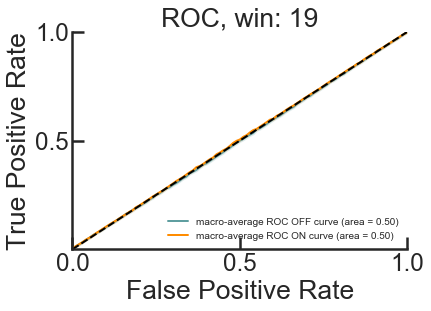

In [80]:

for Win in range(2,20):
    Window = Win
    n_neuron=180 
    inic=n_neuron - int(Window/2)
    fin=n_neuron + int(Window/2)
    wind=1
    reps_=50
    ## get y_off
    y_off=y_off_all
    bool_int = (y_off>=inic) & (y_off<=fin) 
    y_off = y_off[bool_int]
    y_off = np.reshape(y_off, (len(y_off),1))
    y_off= label_binarize(y_off, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
    n_classes = y_off.shape[1]

    ## get X_off
    bool_reshaped = np.reshape(bool_int, (len(bool_int)))
    #### X_off = X_off_all[bool_reshaped,n_neuron]
    X_off = simpl_X_off_all[bool_reshaped]

    X_off =np.reshape(X_off, (len(X_off),1))

    ########################################################################

    ## get y_on
    y_on=y_on_all
    bool_int =  (y_on>=inic) & (y_on<=fin)
    y_on = y_on[bool_int]
    y_on = np.reshape(y_on, (len(y_on),1))
    y_on= label_binarize(y_on, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
    n_classes = y_on.shape[1]

    ## get X_off
    bool_reshaped = np.reshape(bool_int, (len(bool_int)))
    #### X_on = X_on_all[bool_reshaped,n_neuron]
    X_on = simpl_X_on_all[bool_reshaped]

    X_on =np.reshape(X_on, (len(X_on),1))


    ##classifier to use
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000))

    fpr_mean_off = []
    tpr_mean_off = []
    roc_mean_off = []

    fpr_mean_on = []
    tpr_mean_on = []
    roc_mean_on = []



    for stimulation in ['ON', 'OFF']:
        if stimulation=='ON':
            X=X_on
            y=y_on
        elif stimulation=='OFF':
            X=X_off
            y=y_off

        ###
        ### many train and test to validate the measure
        for rep in range(reps_):
            #print(rep)
            ## split train and test
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=None)
            X_train =np.reshape(X_train, (len(X_train),1))
            X_test =np.reshape(X_test, (len(X_test),1))
            # score
            #fitted = classifier.fit(X_train, y_train)
            #y_score = fitted.decision_function(X_test)
            y_score = classifier.fit(X_train, y_train).decision_function(X_test)

            ## Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr= dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            ### Compute mean ROC curve

            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
            #
            if stimulation=='ON':
                fpr_mean_on.append(fpr["macro"])
                tpr_mean_on.append(tpr["macro"])
                roc_mean_on.append(roc_auc["macro"])
            elif stimulation=='OFF':
                fpr_mean_off.append(fpr["macro"])
                tpr_mean_off.append(tpr["macro"])
                roc_mean_off.append(roc_auc["macro"])



    ####
    plt.figure()
    lw = 2

    fpr_mean_off = np.concatenate(fpr_mean_off)
    tpr_mean_off = np.concatenate(tpr_mean_off)
    df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
    df_ROC_OFF = df_ROC_OFF.round(2)


    sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
                 linestyle='--', linewidth=2, 
                 label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



    fpr_mean_on = np.concatenate(fpr_mean_on)
    tpr_mean_on = np.concatenate(tpr_mean_on)
    df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
    df_ROC_ON = df_ROC_ON.round(2)


    sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
                 linestyle='--', linewidth=2, 
                 label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


    ###
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0, 1])
    plt.xticks([0, 0.5, 1])
    plt.ylim([0, 1])
    plt.yticks([0.5, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC, win: ' +str(Window))
    plt.legend(loc="lower right", fontsize=10, frameon=False)
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.show()
    print('')
    print('')

In [81]:
np.arange(20,50,5)

array([20, 25, 30, 35, 40, 45])

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


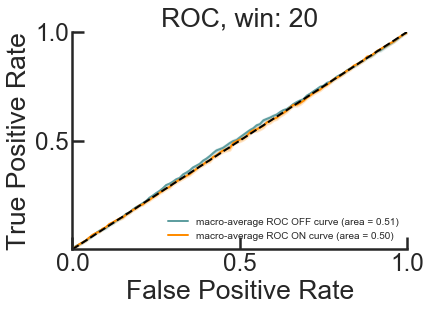

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

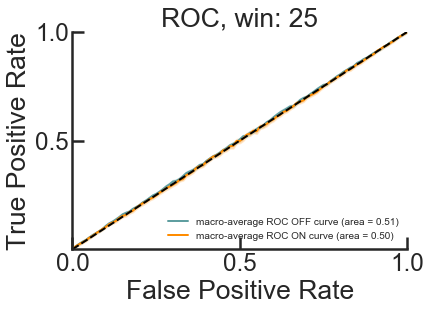

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will

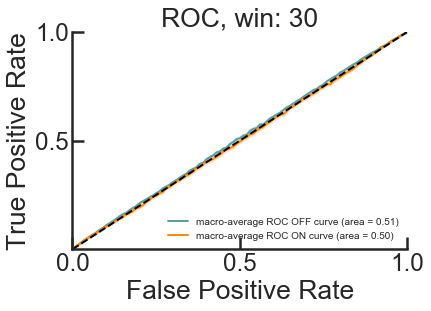

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

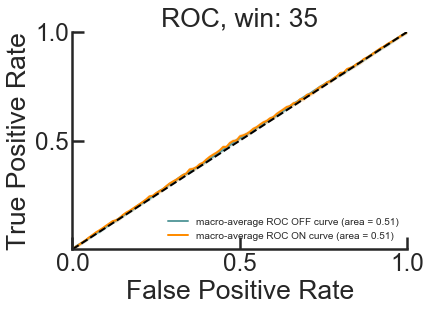

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will

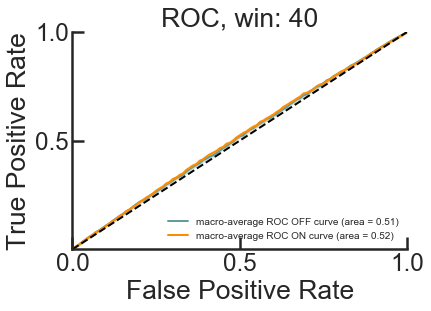

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\sklearn\svm\base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

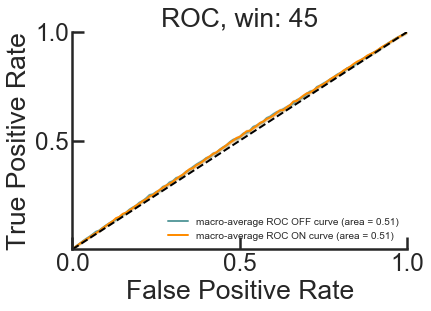

In [82]:

for Win in np.arange(20,50,5):
    Window = Win
    n_neuron=180 
    inic=n_neuron - int(Window/2)
    fin=n_neuron + int(Window/2)
    wind=1
    reps_=10
    ## get y_off
    y_off=y_off_all
    bool_int = (y_off>=inic) & (y_off<=fin) 
    y_off = y_off[bool_int]
    y_off = np.reshape(y_off, (len(y_off),1))
    y_off= label_binarize(y_off, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
    n_classes = y_off.shape[1]

    ## get X_off
    bool_reshaped = np.reshape(bool_int, (len(bool_int)))
    #### X_off = X_off_all[bool_reshaped,n_neuron]
    X_off = simpl_X_off_all[bool_reshaped]

    X_off =np.reshape(X_off, (len(X_off),1))

    ########################################################################

    ## get y_on
    y_on=y_on_all
    bool_int =  (y_on>=inic) & (y_on<=fin)
    y_on = y_on[bool_int]
    y_on = np.reshape(y_on, (len(y_on),1))
    y_on= label_binarize(y_on, classes=np.arange(inic, fin, wind)) #matrix (1,0,0,...,0)
    n_classes = y_on.shape[1]

    ## get X_off
    bool_reshaped = np.reshape(bool_int, (len(bool_int)))
    #### X_on = X_on_all[bool_reshaped,n_neuron]
    X_on = simpl_X_on_all[bool_reshaped]

    X_on =np.reshape(X_on, (len(X_on),1))


    ##classifier to use
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=None, max_iter=10000))

    fpr_mean_off = []
    tpr_mean_off = []
    roc_mean_off = []

    fpr_mean_on = []
    tpr_mean_on = []
    roc_mean_on = []



    for stimulation in ['ON', 'OFF']:
        if stimulation=='ON':
            X=X_on
            y=y_on
        elif stimulation=='OFF':
            X=X_off
            y=y_off

        ###
        ### many train and test to validate the measure
        for rep in range(reps_):
            #print(rep)
            ## split train and test
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=None)
            X_train =np.reshape(X_train, (len(X_train),1))
            X_test =np.reshape(X_test, (len(X_test),1))
            # score
            #fitted = classifier.fit(X_train, y_train)
            #y_score = fitted.decision_function(X_test)
            y_score = classifier.fit(X_train, y_train).decision_function(X_test)

            ## Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr= dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            ### Compute mean ROC curve

            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(n_classes):
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
            #
            if stimulation=='ON':
                fpr_mean_on.append(fpr["macro"])
                tpr_mean_on.append(tpr["macro"])
                roc_mean_on.append(roc_auc["macro"])
            elif stimulation=='OFF':
                fpr_mean_off.append(fpr["macro"])
                tpr_mean_off.append(tpr["macro"])
                roc_mean_off.append(roc_auc["macro"])



    ####
    plt.figure()
    lw = 2

    fpr_mean_off = np.concatenate(fpr_mean_off)
    tpr_mean_off = np.concatenate(tpr_mean_off)
    df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
    df_ROC_OFF = df_ROC_OFF.round(2)


    sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
                 linestyle='--', linewidth=2, 
                 label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



    fpr_mean_on = np.concatenate(fpr_mean_on)
    tpr_mean_on = np.concatenate(tpr_mean_on)
    df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
    df_ROC_ON = df_ROC_ON.round(2)


    sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
                 linestyle='--', linewidth=2, 
                 label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


    ###
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([0, 1])
    plt.xticks([0, 0.5, 1])
    plt.ylim([0, 1])
    plt.yticks([0.5, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC, win: ' +str(Window))
    plt.legend(loc="lower right", fontsize=10, frameon=False)
    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.show()
    print('')
    print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


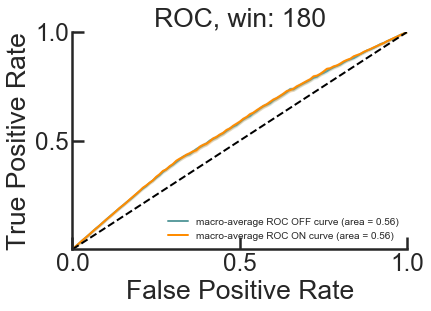

In [64]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


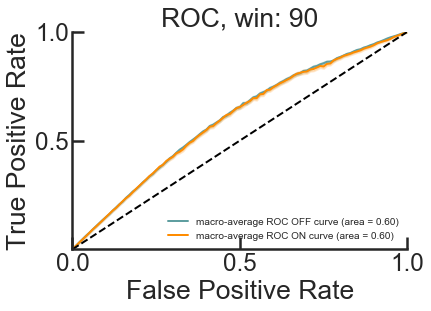

In [60]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


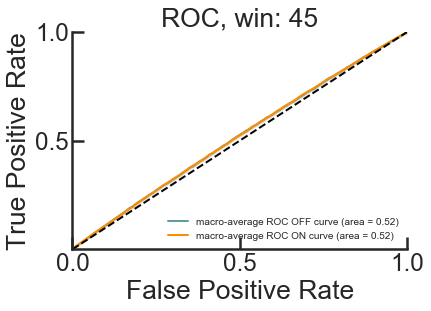

In [58]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


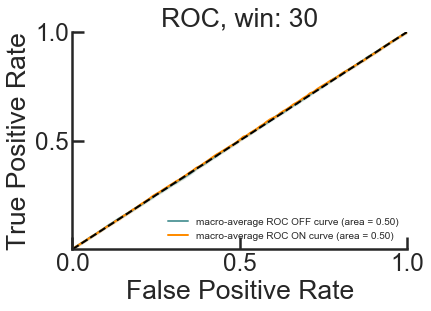

In [56]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


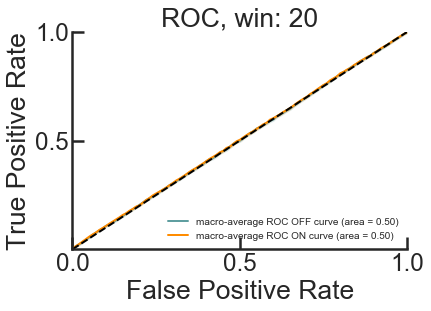

In [49]:
plt.figure()
lw = 2

fpr_mean_off = np.concatenate(fpr_mean_off)
tpr_mean_off = np.concatenate(tpr_mean_off)
df_ROC_OFF = pd.DataFrame({'fpr_mean': fpr_mean_off, 'tpr_mean': tpr_mean_off})
df_ROC_OFF = df_ROC_OFF.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_OFF, color='cadetblue', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC OFF curve (area = {0:0.2f})'''.format(np.mean(roc_mean_off)))



fpr_mean_on = np.concatenate(fpr_mean_on)
tpr_mean_on = np.concatenate(tpr_mean_on)
df_ROC_ON = pd.DataFrame({'fpr_mean': fpr_mean_on, 'tpr_mean': tpr_mean_on})
df_ROC_ON = df_ROC_ON.round(2)


sns.lineplot(x='fpr_mean', y='tpr_mean', data=df_ROC_ON, color='darkorange', 
             linestyle='--', linewidth=2, 
             label='macro-average ROC ON curve (area = {0:0.2f})'''.format(np.mean(roc_mean_on)))


###
plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.ylim([0, 1])
plt.yticks([0.5, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC, win: ' +str(Window))
plt.legend(loc="lower right", fontsize=10, frameon=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.show()
print('')
print('')